Epoch 0000 | Loss: 2.8116e+00 | LR: 1.00e-03
Epoch 0050 | Loss: 4.6911e-03 | LR: 1.00e-03
Epoch 0100 | Loss: 3.1630e-04 | LR: 1.00e-03
Epoch 0150 | Loss: 8.5100e-05 | LR: 1.00e-03
Epoch 0200 | Loss: 3.7450e-05 | LR: 1.00e-03
Epoch 0250 | Loss: 2.0507e-05 | LR: 1.00e-03
Epoch 0300 | Loss: 1.3567e-05 | LR: 1.00e-03
[Epoch 340] Loss stagnated. Reducing learning rate to 1.00e-04
Epoch 0350 | Loss: 9.9780e-05 | LR: 1.00e-04
[Epoch 360] Loss stagnated. Reducing learning rate to 1.00e-05
[Epoch 380] Loss stagnated. Reducing learning rate to 1.00e-06
[Epoch 400] Loss stagnated. Reducing learning rate to 1.00e-07
Epoch 0400 | Loss: 2.6769e-05 | LR: 1.00e-07
[Epoch 420] Loss stagnated. Reducing learning rate to 1.00e-08
[Epoch 440] Loss stagnated. Reducing learning rate to 1.00e-09
Epoch 0450 | Loss: 2.8193e-05 | LR: 1.00e-09
[Epoch 460] Loss stagnated. Reducing learning rate to 1.00e-10
[Epoch 480] Loss stagnated. Reducing learning rate to 1.00e-11
[Epoch 500] Loss stagnated. Reducing learning 

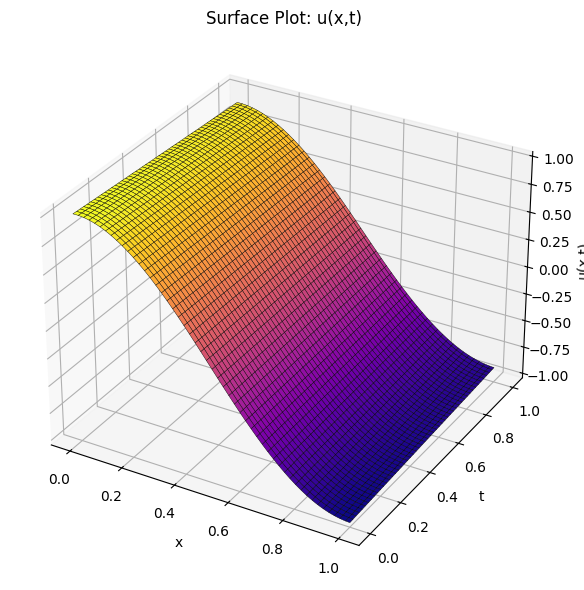

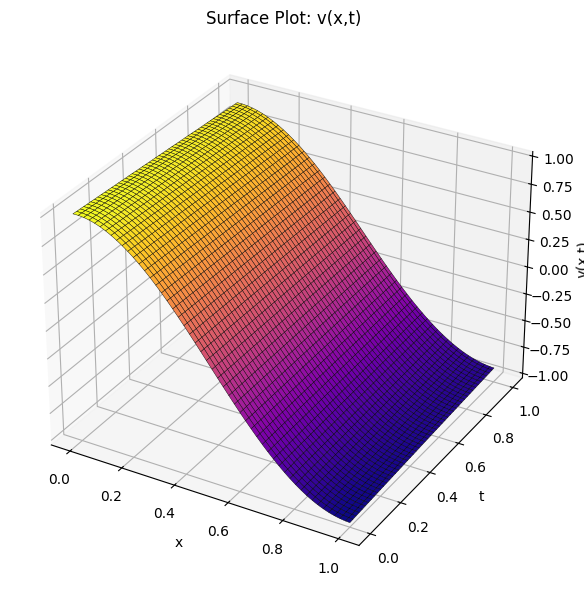

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ----- Device and Constants -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tmin, tmax = 0.0, 1.0
xmin, xmax = 0.0, 1.0
lb = torch.tensor([tmin, xmin], dtype=torch.float32, device=device)
ub = torch.tensor([tmax, xmax], dtype=torch.float32, device=device)

pi = np.pi
epsilon = 0.01  # for Re = 1/epsilon = 100

# ----- Fourier Feature Mapping -----
def fourier_features(x, freqs=[1, 2, 4, 8]):
    out = [x]
    for w in freqs:
        out += [torch.sin(w * x), torch.cos(w * x)]
    return torch.cat(out, dim=1)

def scale_input(x):
    return 2.0 * (x - lb) / (ub - lb) - 1.0

# ----- Network Architecture -----
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class ResidualBlock(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.linear = nn.Linear(width, width)
        self.activation = Swish()

    def forward(self, x):
        return x + self.activation(self.linear(x))

class CoupledNet(nn.Module):
    def __init__(self, in_dim, width=100, depth=8):
        super().__init__()
        self.input_layer = nn.Linear(in_dim, width)
        self.hidden = nn.Sequential(*[ResidualBlock(width) for _ in range(depth)])
        self.output_layer = nn.Linear(width, 2)

    def forward(self, x):
        x = Swish()(self.input_layer(x))
        x = self.hidden(x)
        return self.output_layer(x).split(1, dim=1)

# ----- Exact Solutions for Problem 3 -----
def u_exact(x, t):
    return torch.exp(-epsilon * pi**2 * t) * torch.cos(pi * x)

def v_exact(x, t):
    return torch.exp(-epsilon * pi**2 * t) * torch.cos(pi * x)

# ----- Physics-Informed Residuals -----
def residuals(model, X_r):
    X_r.requires_grad_(True)
    t, x = X_r[:, 0:1], X_r[:, 1:2]
    x_input = torch.cat([t, fourier_features(x)], dim=1)
    u, v = model(x_input)

    grads_u = torch.autograd.grad(u, X_r, torch.ones_like(u), create_graph=True)[0]
    grads_v = torch.autograd.grad(v, X_r, torch.ones_like(v), create_graph=True)[0]

    u_t, u_x = grads_u[:, 0:1], grads_u[:, 1:2]
    v_t, v_x = grads_v[:, 0:1], grads_v[:, 1:2]

    u_xx = torch.autograd.grad(u_x, X_r, torch.ones_like(u_x), create_graph=True)[0][:, 1:2]
    v_xx = torch.autograd.grad(v_x, X_r, torch.ones_like(v_x), create_graph=True)[0][:, 1:2]

    uv = u * v
    uv_x = torch.autograd.grad(uv, X_r, torch.ones_like(uv), create_graph=True)[0][:, 1:2]

    r1 = u_t - epsilon * u_xx + 2 * u * u_x - uv_x
    r2 = v_t - epsilon * v_xx + 2 * v * v_x - uv_x

    return r1, r2

# ----- Data Generation -----
def generate_data(N_0=100, N_b=100, N_r=10000):
    x_0 = (xmax - xmin) * torch.rand((N_0, 1), device=device) + xmin
    t_0 = torch.full_like(x_0, tmin)
    X_0 = torch.cat([t_0, x_0], dim=1)
    u_0 = u_exact(x_0, t_0)
    v_0 = v_exact(x_0, t_0)

    t_b = (tmax - tmin) * torch.rand((N_b, 1), device=device) + tmin
    x_b0 = torch.full_like(t_b, xmin)
    x_b1 = torch.full_like(t_b, xmax)
    X_b = torch.cat([torch.cat([t_b, x_b0], dim=1), torch.cat([t_b, x_b1], dim=1)], dim=0)
    u_b = u_exact(X_b[:, 1:2], X_b[:, 0:1])
    v_b = v_exact(X_b[:, 1:2], X_b[:, 0:1])

    t_r = (tmax - tmin) * torch.rand((N_r, 1), device=device) + tmin
    x_r = (xmax - xmin) * torch.rand((N_r, 1), device=device) + xmin
    X_r = torch.cat([t_r, x_r], dim=1)

    return X_0, u_0, v_0, X_b, u_b, v_b, X_r

# ----- Loss Function -----
def loss_fn(model, X_r, X_0, u_0, v_0, X_b, u_b, v_b, epoch=0, max_epoch=10000):
    r1, r2 = residuals(model, X_r)
    w_pde = 0.1 + 0.9 * (epoch / max_epoch)

    loss_pde = torch.mean(r1**2) + torch.mean(r2**2)
    x0_input = torch.cat([X_0[:, 0:1], fourier_features(X_0[:, 1:2])], dim=1)
    xb_input = torch.cat([X_b[:, 0:1], fourier_features(X_b[:, 1:2])], dim=1)

    u_pred_0, v_pred_0 = model(x0_input)
    u_pred_b, v_pred_b = model(xb_input)

    loss_ic = torch.mean((u_pred_0 - u_0)**2 + (v_pred_0 - v_0)**2)
    loss_bc = torch.mean((u_pred_b - u_b)**2 + (v_pred_b - v_b)**2)

    return loss_ic + loss_bc + w_pde * loss_pde

# ----- Training -----
def train_model(model, data, epochs=2500, patience=300, lr=1e-3):
    X_0, u_0, v_0, X_b, u_b, v_b, X_r = data
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)
    best_loss, best_state, patience_counter = float('inf'), None, 0

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, X_r, X_0, u_0, v_0, X_b, u_b, v_b, epoch, epochs)
        loss.backward(); optimizer.step(); scheduler.step()

        if loss.item() < best_loss - 1e-10:
            best_loss, best_state, patience_counter = loss.item(), model.state_dict(), 0
        else:
            patience_counter += 1

        if patience_counter % 20 == 0 and patience_counter > 0:
            for g in optimizer.param_groups:
                g['lr'] /= 10
            print(f"[Epoch {epoch}] Loss stagnated. Reducing learning rate to {optimizer.param_groups[0]['lr']:.2e}")

        if epoch % 50 == 0:
            print(f"Epoch {epoch:04d} | Loss: {loss.item():.4e} | LR: {optimizer.param_groups[0]['lr']:.2e}")

        if patience_counter > patience:
            print("Early stopping at epoch", epoch)
            break

    model.load_state_dict(best_state)
    return model

# ----- Visualization -----
def plot_surface(model):
    x_vals = torch.linspace(xmin, xmax, 200, device=device)
    t_vals = torch.linspace(tmin, tmax, 200, device=device)
    X, T = torch.meshgrid(x_vals, t_vals, indexing='ij')
    XT = torch.cat([T.reshape(-1, 1), X.reshape(-1, 1)], dim=1)
    with torch.no_grad():
        X_input = torch.cat([XT[:, 0:1], fourier_features(XT[:, 1:2])], dim=1)
        u_pred, v_pred = model(X_input)
    U = u_pred.reshape(200, 200).cpu().numpy()
    V = v_pred.reshape(200, 200).cpu().numpy()

    for data, name in zip([U, V], ['u', 'v']):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X.cpu(), T.cpu(), data, cmap='plasma', edgecolor='k', linewidth=0.3)
        ax.set_xlabel('x'); ax.set_ylabel('t'); ax.set_zlabel(f'{name}(x,t)')
        ax.set_title(f'Surface Plot: {name}(x,t)')
        plt.tight_layout()
        plt.show()

# ----- Run the Model -----
model = CoupledNet(in_dim=1 + 2 * len([1, 2, 4, 8]) + 1).to(device)
data = generate_data()
model = train_model(model, data, epochs=2000)
plot_surface(model)
